In [1]:
import csv
import os
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from rfpimp import * #for permutation importance

#visualization
from sklearn import preprocessing
from sklearn.tree import export_graphviz
import pydot

For the last two years I've been collecting my own health data on my Garmin VivoActive HR. Unfortunately, the only way I could find to get daily data was to download weekly CSV file from their website for each separate category. I downloaded all of the weekly files for Resting Heart Rate and Daily Steps. This function goes through all of the CSV files in a particular folder and converts them into a single time series.

Note that it skips some weeks. My watch broke for a few weeks back in the summer of 2017. No data exists while I waited for a replacement. (Aside: Garmin was pretty awesome and replaced my watch for free after it got damaged while swimming. They gave another replacement last week for the same problem. Thanks, Garmin!)

In [2]:
def procCSVs(filePath, dataCol=2):
    os.chdir(filePath)
    files = sorted(filter(os.path.isfile, os.listdir('.')), key=os.path.getmtime) #list files by time created
    csv_files = [file for file in files if file[-4:].lower()=='.csv']

    dfRows = []
    i = 0
    date='20180522'
    jDict = {'Tue':0, 'Wed':1, 'Thu':2, 'Fri':3, 'Sat':4, 'Sun':5, 'Mon':6}

    for file in csv_files:
        with open(file, 'r', errors='ignore') as f:
            reader = csv.reader(f)
            for row in reader:
                if row[0]!='':
                    if len(row[0])<6:
                        j = jDict[row[0]]
                        dateTmp = datetime(int(date[:4]),int(date[4:6]),int(date[6:]))
                        dateTmp = dateTmp+timedelta(days=j)
                        dateTmp = dateTmp.strftime('%Y%m%d')
                        row.append(dateTmp)
                        dfRows.append(row)
            if i==43:
                date = '20170704'
            else:
                date = datetime(int(date[:4]),int(date[4:6]),int(date[6:]))
                date = date-timedelta(days=7)
                date = date.strftime('%Y%m%d')

            i += 1

    day = []
    hr = []

    i = 0
    for row in dfRows:
        hr.append(row[1])
        day.append(row[dataCol])
        
    d = {'day':day, 'data':hr}
    df = pd.DataFrame(data=d)
    df = df.sort_values(by=['day']).reset_index(drop=True)

    return df

filePath = 'RestHR'
hr_df = procCSVs(filePath)
filePath = '..\Steps'
step_df = procCSVs(filePath, dataCol=3)

I also have been collecting daily self-reported personal health data. I set up a Google survey to be sent to me every morning. I've been able to fill it out most days. I downloaded all of the data as a CSV froom Google. This section processes all of the data from the daily survey.

In [3]:
os.chdir('..')
healthSurvey_df = pd.read_csv('DailyCheck.csv')
healthSurvey_df['Date'] = pd.to_datetime(healthSurvey_df['Date'])
healthSurvey_df['day'] = healthSurvey_df['Date'].dt.date
healthSurvey_df['day'] = healthSurvey_df.Date.apply(lambda x: x.strftime('%Y%m%d')).astype(int)

Putting the HR and Steps data into a single dataframe, then combining with the survey data

In [4]:
hrStep_df = pd.merge(hr_df, step_df, on='day')
hrStep_df['day'] = hrStep_df['day'].astype(int)
hrStep_df = hrStep_df.rename(columns={'data_x': 'restHR', 'data_y': 'steps'})
hrStep_df['restHR'] = hrStep_df['restHR'].astype(int)
hrStep_df['steps'] = hrStep_df['steps'].astype(int)

all_df = pd.merge(hrStep_df, healthSurvey_df, on='day')

This next section does some feature engineering.

In [5]:
#make binary variable for working out
mask=all_df.loc[:,'Sport']=='none'
all_df.loc[mask,'Workout'] = 0
all_df.loc[~mask,'Workout'] = 1

#change workout time into numerical (middle of range)
mask=all_df.loc[:,'WorkoutTime']=='None'
all_df.loc[mask,'WorkoutTime'] = 0
mask=all_df.loc[:,'WorkoutTime']=='0-30min'
all_df.loc[mask,'WorkoutTime'] = 15
mask=all_df.loc[:,'WorkoutTime']=='30-60 min'
all_df.loc[mask,'WorkoutTime'] = 45
mask=all_df.loc[:,'WorkoutTime']=='60-90min'
all_df.loc[mask,'WorkoutTime'] = 75
mask=all_df.loc[:,'WorkoutTime']=='90-120min'
all_df.loc[mask,'WorkoutTime'] = 105
mask=all_df.loc[:,'WorkoutTime']=='>120 min'
all_df.loc[mask,'WorkoutTime'] = 135
all_df.loc[mask,'WorkoutTime'] = all_df.loc[mask,'WorkoutTime'].astype(int)

#drop data fields that may not be related to outcome
all_df = all_df.drop(columns=['Date', 'WorkoutStart', 'Sport'])

#it may be more interesting to look at the previous day for some features
#how many drinks did I have the day before?
all_df.Drinks = all_df.Drinks.shift(1)
# how healthy did I eat the day before?
all_df.Eat = all_df.Eat.shift(1)
# how did I sleep the night before?
all_df.Sleep = all_df.Sleep.shift(1)

#get rid of days where not all fields are complete
all_df = all_df.drop([0])
all_df.head()

all_df = all_df.set_index('day')
# one-hot encoding for sleep
all_df = pd.get_dummies(all_df)


Let's take a look at some of the features and see if there is anything interesting going on.

First, what do the time series look like?

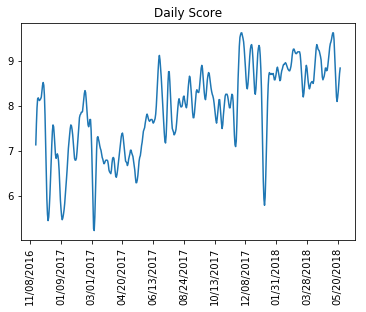

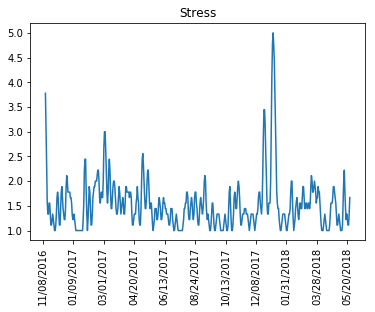

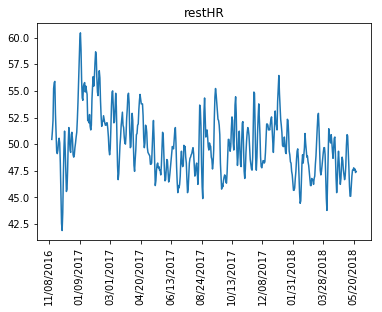

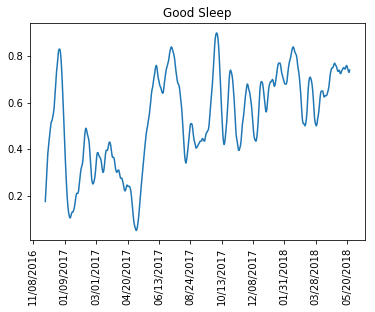

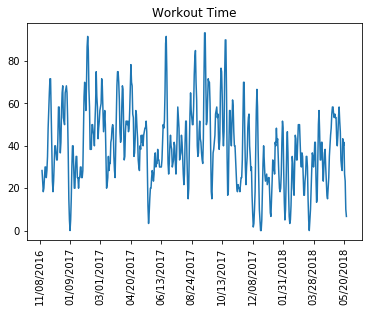

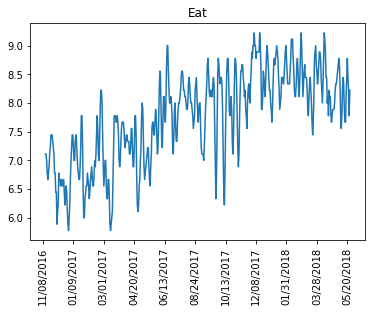

In [6]:
norm_df = all_df.reset_index()


dates = []
for iDay in range(0, len(all_df.index)):
    day = str(all_df.index[iDay])
    dates.append(datetime.strptime(day, '%Y%m%d').strftime('%m/%d/%Y'))

plt.plot(norm_df['DayScore'].rolling(10, win_type='triang').mean())
plt.xticks(np.arange(0,len(dates),50), dates[0:len(dates):50], rotation='vertical')
plt.title('Daily Score')
plt.show()

plt.plot(norm_df['Stress'].rolling(5, win_type='triang').mean())
plt.xticks(np.arange(0,len(dates),50), dates[0:len(dates):50], rotation='vertical')
plt.title('Stress')
plt.show()

plt.plot(norm_df['restHR'].rolling(5, win_type='triang').mean())
plt.xticks(np.arange(0,len(dates),50), dates[0:len(dates):50], rotation='vertical')
plt.title('restHR')
plt.show()

plt.plot(norm_df['Sleep_Yes'].rolling(20, win_type='triang').mean())
plt.xticks(np.arange(0,len(dates),50), dates[0:len(dates):50], rotation='vertical')
plt.title('Good Sleep')
plt.show()

plt.plot(norm_df['WorkoutTime'].rolling(5, win_type='triang').mean())
plt.xticks(np.arange(0,len(dates),50), dates[0:len(dates):50], rotation='vertical')
plt.title('Workout Time')
plt.show()

plt.plot(norm_df['Eat'].rolling(5, win_type='triang').mean())
plt.xticks(np.arange(0,len(dates),50), dates[0:len(dates):50], rotation='vertical')
plt.title('Eat')
plt.show()

The time series data reveals some interesting trends. First, there are a few notable events that drive the variables. I got mono at the end of 2016 (started to get sick around Christmas). My resting hear rate started to trend up before getting sick and peaked at above 60! It then tended back down as I got recovered.

I broke up with a girlfriend at the end of Feb 2017, which led to a drop in the daily score and  a small increase in stress. The daily score remained low for about 3 months then started to trend back up around the time I met my current partner.

Finally, I had my PhD defense in early January. There's a pretty big jump in stress around this time and and a smaller drop in my daily score. Not much else seemed to change much despite the increased stress.

Looking over a longer time scale, there's a few pretty clear trends: My daily score has been going up, I've been eating healthier, I've been sleeping better and my resting heart rate has been going down. On the negative side, I've been working out less.

How do day-to-day changes in these things effect how I feel about a day? Lets dig in some more.

How correlated are the features with each other and with the outcome? Naively, I would guess that some of the features may be correlated. For example, I may sleep better if I workout for a long time. These correlations may lead to mischaracterization of feature importance in the model.

               restHR     steps  DayScore    Stress    Drinks  WorkoutTime  \
restHR       1.000000 -0.020839 -0.118003  0.124237 -0.040104     0.289028   
steps       -0.020839  1.000000  0.035781  0.036051  0.017206    -0.096582   
DayScore    -0.118003  0.035781  1.000000 -0.380857  0.024192     0.088823   
Stress       0.124237  0.036051 -0.380857  1.000000 -0.117557    -0.100997   
Drinks      -0.040104  0.017206  0.024192 -0.117557  1.000000     0.128891   
WorkoutTime  0.289028 -0.096582  0.088823 -0.100997  0.128891     1.000000   
Eat         -0.143197  0.107091  0.291647 -0.038025 -0.199616    -0.102830   
Workout      0.193110 -0.075418  0.076671 -0.061241  0.039744     0.741122   
Sleep_Maybe  0.071049 -0.040084 -0.135613  0.102372  0.002226    -0.002752   
Sleep_No     0.057604 -0.078074 -0.180068  0.008305  0.249229     0.016980   
Sleep_Yes   -0.102748  0.084751  0.237324 -0.104149 -0.148624    -0.007310   

                  Eat   Workout  Sleep_Maybe  Sleep_No  Sleep_Y

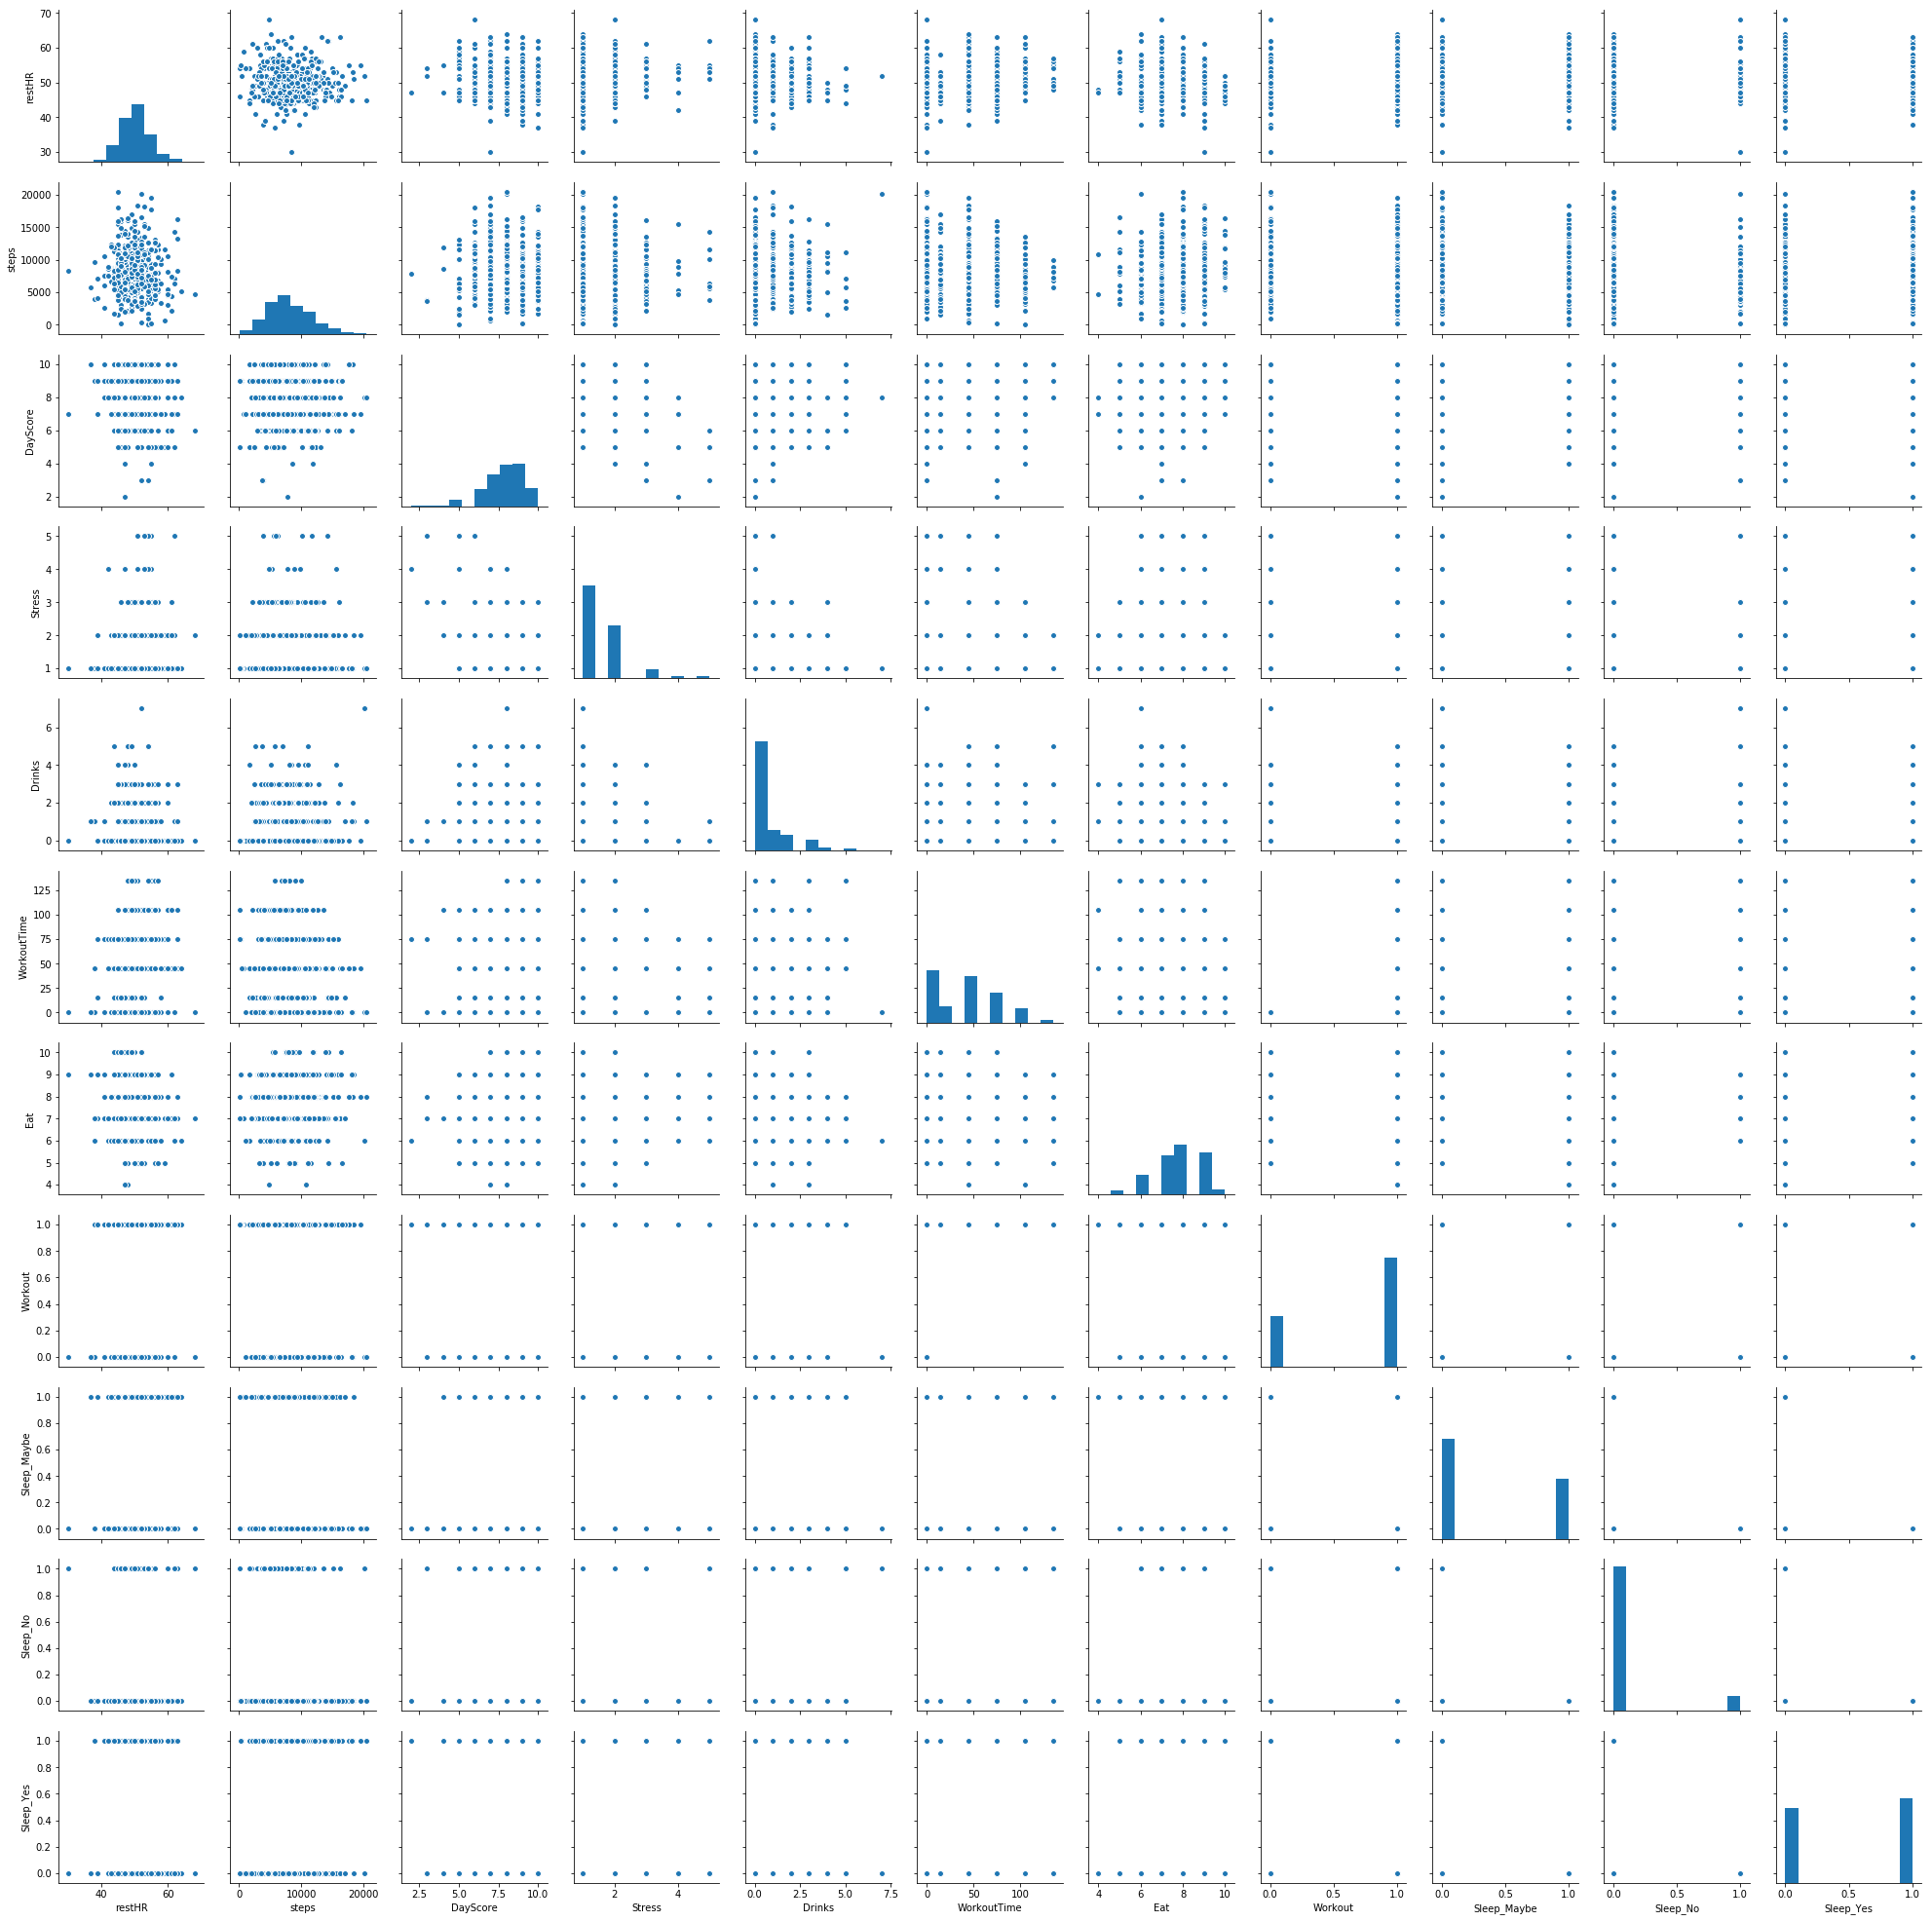

In [7]:
sns.pairplot(all_df)
print(all_df.corr())

Interstingly, the features are not that correlated with each other or with the outcome. This suprised me! I thought that at least some things would be more closely related. Though there are some smaller correlations (e.g. Stress and Daily Score) nothing stands out as being to strong. Lets see what a more sophisticated model has to say!

I'll separate out outcome (self-reported score for the day) from features.

In [8]:
labels = all_df.pop('DayScore')
#labels = np.array(labels)
features = all_df
#features = np.array(all_df)
feature_list = list(all_df.columns)
all_df.head()

,restHR,steps,Stress,Drinks,WorkoutTime,Eat,Workout,Sleep_Maybe,Sleep_No,Sleep_Yes
day,,,,,,,,,,
20161108,46,6875,2,3.0,0,7.0,1.0,0,1,0
20161109,51,14242,5,1.0,15,6.0,1.0,1,0,0
20161110,54,3812,5,1.0,75,8.0,1.0,0,1,0
20161111,48,13544,2,0.0,0,7.0,0.0,0,1,0
20161112,48,16151,3,0.0,0,7.0,0.0,1,0,0


Next I'll split the data into a trianing (75%) and test (25%) set.

In [9]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

Here I run a random forest regression model to predict the my score for the day based on my daily activity/health data. I chose to use a decision tree model because it may help me decide what to do on any particular day to maximize the likelihood that I have a "good day" (that it scores high on my 1-10 estimation).

MAE: 0.95
Accuracy: 86.71 %.


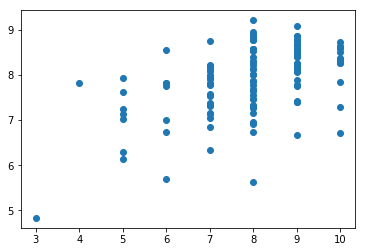

In [10]:
# Make model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 17)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print('MAE:', round(np.mean(errors), 2))
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

plt.plot(test_labels, predictions, 'o')
plt.show()

Visualizing decision tree model.

In [11]:
# Import tools needed for visualization
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 4)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

What are the features that contribute most to the "goodness" of my day? The RandomForestRegressor class from scikit-learn provides a measure called the mean decrease in impurity, which gives an estimate of the feature importance. The MDI measures the amount that all splits using the feature of interest reduce the overall variance. A greater MDI means that the feature plays a larger role in predicting the outcome.

Using the MDI, the number of steps I take in a day see to be the most important feature for estimating the daily score. This was a surprise to me. I expected stress, working out and sleep to be the main drivers of my estimates of personal health. But steps may reveal something that I wasn't suspecting: The more I walk around means more time doing activities (such as going out to a concert or walking through Central Park), which definitely would lead to me feeling like I had a good day.

The next two features are stress and resting HR. I expected stress to be at the top, but maybe this is evidence that I am able to psychology tolerate stressful days. Sometimes I feel like a stressful can be a good day because it leads to productivity.

Eating/Alcohol, working out and sleep all contribute as well, although somehwat less than I thought they would based on my qualitative estimate.

So I guess I should be walking more. Importantly, I suspect that the walk to make the walking most effective is to do it during little breaks in the day. Like taking a long walk to get lunch, or going for a 15 minute stroll through Washington Square Park in the afternoon.

In [12]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: steps                Importance: 0.31
Variable: restHR               Importance: 0.16
Variable: Stress               Importance: 0.15
Variable: Eat                  Importance: 0.12
Variable: WorkoutTime          Importance: 0.09
Variable: Drinks               Importance: 0.06
Variable: Sleep_Yes            Importance: 0.04
Variable: Sleep_No             Importance: 0.03
Variable: Workout              Importance: 0.02
Variable: Sleep_Maybe          Importance: 0.02


The results are interesting, but its worth pointing out a number of limitations of this analysis.

First, I've only tracked a small number of variables from my day. This was due to limitations in the device that I was using and the entries that I put on the survey. For example, I imagine that the amount of sleep is important to my overall well being. However, this isn't tracked on my VivoActive HR so I don't have that data. The same is true for how many hours I spent at work, how much time I was seated each day, etc. These metrics may cover some of the unexplained variance in my daily scores.

Possibly more importantly, a lot of the data is a self reported estimate. Self reported estimates can be subject to bias. Take a look at the distribution of daily scores and stress:

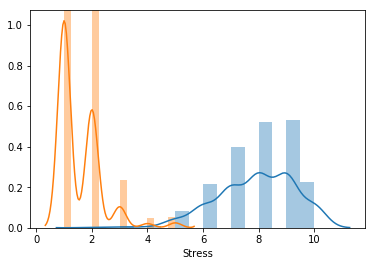

In [13]:
sns.distplot(labels)
sns.distplot(features['Stress'])

My daily score estimate is almost all >5, meaning I generally have a "good" day. This may reflect a general optimistic bias that I have. Likewise the stress score is almost always 1 or 2, meaning that I never perceive myself as being stressed. A daily measurement of cortisol may give a less biased estimate of stress.

Aside from being biased, the self-reported scores may be incorrect due to measurement problems. My estimates rely on my perceptions, which may not be correct. For exmaple, my eating score may not accurately measure the healthiness of what I ate. When I order something on Seamless, I don't really know all the nutrional data. And even if I eat something that I do have acess to the data, I may not be accurately remembering it when I fill out the survey in the following morning. A food tracker app may help solve this problem, but I have yet to find anything that is both accurate and easy to use (suggestions welcome!).

Both of these problems lead to another concern: sparsity. If I don't have enough "high" stress day samples, it can be hard to make predictions with this feature. 

These issues may offer an alternative explanation to why steps and resting HR are the most imporant features. They are the least biased, most accurately measured features. Therefore, they may be less noisy and more accurate predicting the data. As with all analysis projects, I want more data to get a better picture! In the mean time I'll be walking more, keeping my resting HR and stress down (maybe yoga/meditation?) and not worrying too much about not getting in a workout every day!!!